# import libraries

In [21]:
#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
import sklearn
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from scipy.stats import norm, kurtosis
from pandas.plotting import scatter_matrix
from scipy.ndimage import gaussian_filter
import time
from scipy import ndimage
from scipy.stats import chi2
from scipy.optimize import curve_fit
#
warnings.filterwarnings('ignore')

#--- user modules
import mdspy as lp
import imp
imp.reload(lp)

#--- 
matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!

# utility functions

In [2]:
def GetMismatchIco(atoms,box,
                   df_comp,
                   xlin,ylin,zlin,
                  ):
    nx,ny,nz = len(xlin), len(ylin), len(zlin)
    #--- partition box & assign index to each atom
    wrap = lp.Wrap(atoms,box)
    wrap.WrapCoord() #--- wrap inside
    wrap.Set(atoms)
    assert np.sum(wrap.isInside()) == len(atoms.x)
    wrap.GetDimensionlessCords()
    AtomCellId = (wrap.beta * np.array([nx,ny,nz])).astype(int)
    #--- store in a df
#    pdb.set_trace()
    tmp=df_comp.set_index(['indxx','indxy','indxz'])
    return tmp.loc[list(AtomCellId)]['deltaa'].to_list()

def GetComp( atoms, atomf ):
    #--- different types
    types = list(set(atomf.type))
    types.sort()
    ntype=len(types)
    c=np.zeros(ntype) #{}
    n = len(atoms.x)
    for typei,indxx in zip(types,range(ntype)):
#        c[typei] = 1.0*np.sum(atoms.type == typei)/n
        c[indxx] = 1.0*np.sum(atoms.type == typei)/n

    return c

def GetDelta(df, AtomicRadius):
    size = list(map(AtomicRadius.get,list(map(int,df['type'].tolist()))))
    assert len(size) == len(df)
    df = pd.DataFrame(np.c_[df,size],columns=list(df.keys())+['size'])
    assert df['size'].mean() > 0.0
    assert df['size'].std() >= 0.0, 'increase size!'
    return df['size'].std()/df['size'].mean()

def GetPressComp( atoms,box, dmean, AtomicRadius, **kwargs ):
#    pdb.set_trace()
    #--- grid: tiling mapped box with original size
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box.CellOrigin, 
                                                     box.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean, odd = False )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))
    dvol = (xlin[1]-xlin[0])*(ylin[1]-ylin[0])*(zlin[1]-zlin[0])
    (ny,nx,nz) = xv.shape
#     nx -= 1
#     ny -= 1
#     nz -= 1
    assert nx*ny*nz >= 8, 'decrease division length!'
    print(dmean,nx*ny*nz)
    #--- indices
    (xvi, yvi, zvi) = np.meshgrid(np.arange(0,nx),np.arange(0,ny),np.arange(0,nz))
    indices = np.array(list(zip(xvi.flatten(), yvi.flatten(), zvi.flatten()))) #--- shape:(ncel,3)
    indices = list(map(lambda x: tuple(x),indices))

    #--- partition box & assign index to each atom
    wrap = lp.Wrap(atoms,box)
    wrap.WrapCoord() #--- wrap inside
    wrap.Set(atoms)
    assert np.sum(wrap.isInside()) == len(atoms.x)
    wrap.GetDimensionlessCords()
    AtomCellId = (wrap.beta * np.array([nx,ny,nz])).astype(int)
    #--- store in a df
    df = pd.DataFrame(np.c_[pd.DataFrame(atoms.__dict__),AtomCellId],
                         columns=list(pd.DataFrame(atoms.__dict__).keys())+['ix','iy','iz'])
    df['ix']=df['ix'].astype(int)
    df['iy']=df['iy'].astype(int)
    df['iz']=df['iz'].astype(int)
#    display(df.head())

    #--- group & compute p and c
    d = df.groupby(by=['ix','iy','iz']).groups
    assert len(d) == nx*ny*nz, 'empty boxes!'
#     #--- lambda function: compute p 
#     f = lambda x: np.sum(np.sum(np.array(x.sxx)+np.array(x.syy)+np.array(x.szz)))*(-1.0e-4/3.0/dvol)
#     vol=np.linalg.det(box.CellVector)
#    pdb.set_trace()
    #
    
    keys = d.keys()
    plist = list(map(lambda x:GetDelta(df.iloc[d[x]],AtomicRadius),keys)) #--- len(plist) = ncell
    clist = list(map(lambda x:GetComp(df.iloc[d[x]],atoms),keys)) #--- clist[icell]={1:c1,2:c2, ...}

    #--- make a data frame
    types = list(set(atoms.type))
    types.sort()
    cols = list(map(lambda x:'Type%s'%x,types))
#    pdb.set_trace()
    df_comp = pd.DataFrame(np.concatenate((np.c_[indices],np.c_[xi],np.c_[clist],np.c_[plist]),
                                          axis=1,dtype=np.object),
                           columns=['indxx','indxy','indxz','x','y','z']+cols+['deltaa'])
    
#    pdb.set_trace()
    #---
    
    
    #--- read file: elastic constants
#     if 'MODU' in kwargs and kwargs['MODU']:
#         fileName = kwargs['PATH']
#         modu = pd.read_csv(fileName, sep=' ',header=0)
# #        display(modu.head())
#         if 'PLOT' in kwargs and kwargs['PLOT']:
#             plott(modu['C66'],nx,ny,nz,box,zlin, 'muCG.png')

    #--- plot
    #--- reshape value


        
#        display(modu.head())
#     if 'MODU' in kwargs and kwargs['MODU']:
#         mlist = modu['C66'].to_list()
#         return clist, plist, mlist
#     else:
    return (xlin,ylin,zlin), df_comp

def PltBinary(xlin,ylin,zlin, 
              val,
              box0,
              thresh = 0.0,
              **kwargs,
             ):
    #--- reshape value
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    value = np.c_[val].reshape(((ny,nx,nz)))

    #--- mean & variance

    #--- xy plane
    #--- 2d slice
    nzl=[0]
    value2d = Get2dSlice( value, zlin, 
                        zlin[-1], nzll=nzl  )
    #--- plot
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
    PltBitmap(value2d<thresh, 
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 1.0, #--- plot a patch
              **kwargs
            )
    return value

def GetVolume(lmpData,itimee):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itimee], AddMissing = np.array([0.0,0.0,0.0] ))
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )
    return np.linalg.det( CellVectorOrtho )



def row_histogram(a):
    ca = np.ascontiguousarray(a).view([('', a.dtype)] * a.shape[1])
    unique, indices, inverse = np.unique(ca, return_index=True, return_inverse=True)
    counts = np.bincount(inverse)
    sort_indices = np.argsort(counts)[::-1]
    return (a[indices[sort_indices]], counts[sort_indices])


        
def GetMotifs( lmpData, times, Plot = True ):
    Unique_indices={}
    Counts = {}
    for itime in times:
        vor = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
        #
        voro_indices = np.c_[vor.VoronoiIndex3,vor.VoronoiIndex4,vor.VoronoiIndex5,vor.VoronoiIndex6].astype(int)
        # Compute frequency histogram.

        unique_indices, counts = row_histogram(voro_indices)
        Unique_indices[itime]=unique_indices[:]
        Counts[itime]=100.0*counts/len(voro_indices)
        #
        # Print the ten most frequent histogram entries.
        if Plot:
            for i in range(10):
                print("%s\t%i\t(%.1f %%)" % (tuple(unique_indices[i]), 
                                         counts[i], 
                                         100.0*float(counts[i])/len(voro_indices)))
                plt.bar(str(tuple(unique_indices[i])), 100.0*float(counts[i])/len(voro_indices),color='C0')
            #
#             plt.yscale('log')
#             plt.ylim(.1,100)
            plt.xlabel('Voronoi Index(n3,n4,n5,n6)',fontsize=16)
            plt.ylabel('Percentage',fontsize=16)
            plt.tick_params(labelrotation=90,labelsize=16)
            #
            plt.savefig('motifs.png',dpi=75,bbox_inches='tight')
            plt.show()
            
    return Unique_indices, Counts


def PdfCondD2min( lmpData, lmpDmin, times,     
                  Plot = True, title='pdfCondD2min.png',
                 axisLabels = True,
                ):
    #--- plot
    if Plot:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        #
        ax.set_yscale('log')
        #ax.set_xscale('log')
        #
        ax.set_ylim(1,1e4)
        ax.set_xlim(-1,3)
        #
        if axisLabels:
            ax.set_xlabel(r'log$D^2$min($A^2$)',fontsize=16)
            ax.set_ylabel(r'PDF',fontsize=16)
        #
        #ax.set_title(r'itime=%s'%itime)
        #
        PutMinorTicks( ax, LOGY = True)
        #
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)

    valueFiltrd = {}
    valueTot = {}
    for itimee in sorted(times): 

        # strain
        ebulk = GetStrain(lmpData, itimee, 0 )
#         if ebulk == 0.0:
#             continue

        #--- d2min and vor
        d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itimee].to_dict(orient='list') )
        vor = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )

        #--- filter
        indices = GetFullIcosahedra( vor )

        #--- histogram: total
        value = valueTot[itimee]=np.array(d2min.d2min)
        hist, edges, error = GetPDF( np.log10(value), 
                                    linscale = True, 
                                    n_per_decade=32,
                                    density = False,
                                   )
        #--- filtered
        value = valueFiltrd[ itimee ] = np.array(d2min.d2min)[indices]
        hist_filtrd, edges_filtrd, error_filtrd = GetPDF( np.log10(value), 
                                                         linscale = True, 
                                                         n_per_decade=32,
                                                         density = False,
                                                        )
        #--- invert
        valinv = np.array(d2min.d2min)[~indices]
        hist_inv, edges_inv, error_inv = GetPDF( np.log10(valinv), 
                                                linscale = True, 
                                                n_per_decade=32,
                                                density = False,
                                               )


        if Plot:
            attr = { 'markersize':10,'markeredgewidth':0.7,
                     'linewidth':.5,'barsabove':None,'capsize':5,
                     'capthick':1,'elinewidth':1}
            #
    #             ax.errorbar(edges,hist,error,fmt='-o',
    #                         markersize=8,markeredgewidth=0.7,
    #                         linewidth=.5,
    #                          barsabove=None,capsize=5,capthick=1,elinewidth=1,label='Total')
                #
            ax.errorbar(edges_filtrd,hist_filtrd,error_filtrd,
                        **attr,
                        fmt='-o', color='black', 
                        markerfacecolor='white', markeredgecolor=None,
                        label='Icosahedra', markevery = int(len(edges_filtrd)/10),
                        errorevery = int(len(edges_filtrd)/10),
                       )
            #
            ax.errorbar(edges_inv,hist_inv,error_inv,
                        **attr,
                        fmt='-s', color='red',
                        markerfacecolor=None, markeredgecolor='black',
                        label='Non Icosahedra',markevery = int(len(edges_inv)/10),
                        errorevery = int(len(edges_inv)/10),
                       )
    #
    if Plot:
        ax.legend(frameon=False, fontsize=12)
        #
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
        #
        plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()

    return valueFiltrd,valueTot


def PlotPaperVersion(pathh_indx,file0_indx,**kwargs):
    verbose = True if 'verbose' in kwargs and kwargs['verbose'] == True else False
    #--- setup symbols
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']

    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    #
    if 'ylabel' in kwargs:
        ax.set_ylabel(kwargs['ylabel'],fontsize=20)
    if 'xlabel' in kwargs:
        ax.set_xlabel(kwargs['xlabel'],fontsize=20)
    ax.tick_params(labelsize=20)
    #
    for mg, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                           'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                            'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):
        if 'glass' in kwargs and kwargs['glass'] != mg:
            continue
            
        Xdata = []#None
        Ydata = []#None
        #--- loop over realizations 
        for irun in [0,1,2]:
            xdata_timeseries = []
            ydata_timeseries = []
        #--- loop over time
    #        for itimee, marker, color, fillstyle in list(zip( [0,50,101,120,195],
    #                                                          markers, colors, fillstyles)): #:
            for itimee in range(0,200+1,2): #range(0,201,1): #(0,208,8):
            #--- store ensemble average

                pathh = { 
                          0:'%s/PairCrltnT300/%s/Run%s'%(os.getcwd(),mg,irun),
                          1:'%s/VorAnlT300/%s/Run%s'%(os.getcwd(),mg,irun),
                          2:'%s/D2minAnalysisT300/%s/Run%s'%(os.getcwd(),mg,irun),
                          3:'%s/ElasticityT300/%s/itime%s/Run%s'%(os.getcwd(),mg,itimee,irun),
                          4:'%s/ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(os.getcwd(),mg,itimee,irun),
                        }[pathh_indx]
                file0 = {
                          0:'%s/gr.txt'%pathh,
                          1:'%s/icoPercentageWithStrain.txt'%pathh,
                          2:'%s/d2min_gamma.txt'%pathh,
                          3:'%s/rc_d2min.txt'%pathh,
                          4:'%s/crsD2minRhoSro.txt'%pathh,
                          5:'%s/NegativeModulus.txt'%pathh, 
                          6:'%s/YieldDelta.txt'%pathh, 
                          7:'%s/gr_peak_gamma.txt'%pathh, 
                          8:'%s/muClustersize_gamma.txt'%pathh, 
                          9:'%s/pdfMu.txt'%pathh, 
                          10:'%s/mu_mean_std.txt'%pathh, 
                          11:'%s/mu_mean_std.txt'%pathh, 
                          12:'%s/pdfClsSize.txt'%pathh,
                          13:'%s/muClustersize_gamma.txt'%pathh, 
                          14:'%s/muClustersize_gamma.txt'%pathh, 
                          15:'%s/muClustersize_gamma.txt'%pathh, 
                        }[file0_indx]
#                print(file0)
                xdata = [np.nan]
                ydata = [np.nan]
                erry = [np.nan]
                if os.path.isfile( file0 ): # and os.path.isfile( file1 ):
#                    os.system('cat %s >> crMuRho_concat.txt' %file0 )
#                    os.system('cat %s >> mu_size.txt'%file1)
                
                    #--- load data
                    sarr = np.loadtxt(file0)
#                    sarr2nd = np.loadtxt(file1)

                    try:

                        #--- assign x, y
    #                    print(sarr.shape)
                        if file0_indx == 5:
                            xdata = np.array([sarr[0]])
                            ydata = np.array([-sarr[1]])
                        elif file0_indx == 6 or file0_indx == 8 or file0_indx == 10 or file0_indx == 13:
                            xdata = np.array([sarr[0]])
                            ydata = np.array([sarr[1]])
                        elif file0_indx == 11 or file0_indx == 14:
                            xdata = np.array([sarr[0]])
                            ydata = np.array([sarr[2]])
                        elif file0_indx == 15:
                            xdata = np.array([sarr[1]])
                            ydata = np.array([sarr[2]])
                        else:
                            xdata = sarr[:,0] #--- x
                            ydata = sarr[:,1] #--- y
                        if file0_indx == 9 or file0_indx == 12:
                            erry = sarr[:,2] #--- error
                            
                        #--- only for shear band width
                        if file0_indx == 3:
                            ydata2 = sarr[:,2] #--- y1
                            #--- remove nan's
                            indices = np.any(~np.isnan(np.c_[ydata,ydata2]),axis=1) #--- true:either x or y is not nan
                            ydata = np.array(list(map(lambda x:np.mean(x[~np.isnan(x)]),np.c_[ydata,ydata2][indices]))) #--- take mean                    
                            xdata = xdata[indices]
                            assert xdata.shape == ydata.shape
                    except:
                        print('error while reading %s'%file0)
                        pass
                    
#                    print(Xdata.shape)
#                    print(xdata,ydata)
#                    print('Xdata=',Xdata,Ydata)
                
                xdata_timeseries += list(xdata) #--- concat different times
                ydata_timeseries += list(ydata)
#                print(xdata_timeseries,ydata_timeseries)
#                print(xdata,ydata)
            #--- ensemble average


            #--- rescale data
            if file0_indx == 15:
                pmax = np.max(xdata_timeseries)
#                print(mg,pmax)
                #
                tmp = np.array(xdata_timeseries)
                tmp.sort()
                q=0.95
                ns=len(tmp)
                pmax = tmp[int(q*ns)]
                #
#                print(mg,pmax)
                xdata_timeseries = 1.0 - np.array( xdata_timeseries ) / pmax 
    
            #--- concat
            try:
                Xdata = np.concatenate((Xdata,xdata_timeseries),axis=0) #--- concat different realizations
                Ydata = np.concatenate((Ydata,ydata_timeseries),axis=0) 
            except:
                traceback.print_exc()
                Xdata = xdata_timeseries.copy()
                Ydata = ydata_timeseries.copy()
                

            if not 'PlotMean' in kwargs or not kwargs['PlotMean']:
                #--- graph-related attributes
#                     attrs={ 
#                             'color':color,
#                             'markersize':10,
#                             'marker':marker,
#                             'markerfacecolor':fillstyle,
#                             'markeredgecolor':'black' if not fillstyle else None,
#                             'label':'%s/irun%s'%(mg,irun),
#                             'markevery':max(1,int(len(xdata)/10.0)),
#                           }
                attrs={ 'color':color,
                        'markersize':10,
                        'marker':marker,
                        'markerfacecolor':fillstyle,
                        'markeredgecolor':'black' if not fillstyle else None,
                        'label':'%s/irun%s'%(mg,irun),
                       'markevery':max(1,int(len(xdata)/10.0)),
                       'errorevery':max(1,int(len(xdata)/10.0)),
                       'markeredgewidth':0.7,
                        'linewidth':1, 
                       'barsabove':None,
                       'capsize':5,
                       'capthick':1,
                       'elinewidth':1,
                       'fmt':'.',
                      }                    
                #--- plot ydata
#                     print(xdata,ydata,erry)
                PltErr(xdata_timeseries,ydata_timeseries, 
                       yerr=None, #erry, #0*ydata,      
                       ax = ax,
                       attrs = attrs,
                       Plot = False,
                       **kwargs,
#                           xerr=yerr0,
                      )
                #--- plot ydata2
#                         PltErr(xdata,ydata2, 
#                                yerr=None, #0*ydata,      
#                                ax = ax,
#                                attrs = attrs,
#                                Plot = False,
#                                **kwargs,
#     #                           xerr=yerr0,
#                               )

    #
        if 'PlotMean' in kwargs and kwargs['PlotMean']:
            Xdata = Xdata[~np.isnan(Ydata)]
            Ydata = Ydata[~np.isnan(Ydata)]
            if verbose:
                print('ydata=',Ydata)
            try:
                #--- take average
                nbins=1024
                if file0_indx == 8:
                    nbins=1
                Xbin, Ybin, Yerr = BinData(Xdata,Ydata,nbins=nbins)
#                    print('xx=',Xbin,Ybin,Yerr)
                attrs={ 'color':color,
                        'markersize':10,
                        'marker':marker,
                        'markerfacecolor':fillstyle,
                        'markeredgecolor':'black' if not fillstyle else None,
                        'label':'%s'%(mg),
                       'markevery':max(1,int(len(Xbin)/10.0)),
                       'errorevery':max(1,int(len(Xbin)/10.0)),
                       'markeredgewidth':0.7,
                        'linewidth':1, 
                       'barsabove':None,
                       'capsize':5,
                       'capthick':1,
                       'elinewidth':1
                      }

                PltErr(Xbin,Ybin, 
                       yerr=Yerr,      
                       ax = ax,
                       attrs = attrs,
                       Plot = False,
                       **kwargs,
                #      xerr=yerr0,
                      )
            except:
#                    traceback.print_exc()
                pass

        
    #
    LOGY = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
    LOGX = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
    PutMinorTicks(ax, LOGX=LOGX,LOGY=LOGY)
    #
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'],LOG_Y=LOGY,LOG_X=LOGX)
    #
    if 'legend' in kwargs and kwargs['legend']:
#        fig.legend(bbox_to_anchor=(1.5,.8))
        ax.legend(frameon=False, fontsize=12, markerscale=0.8,handlelength=1.3,handletextpad=0.4)
    #
    plt.savefig(kwargs['title'] if 'title' in kwargs else 'junk.png',
                dpi=kwargs['dpi'] if 'dpi' in kwargs else 75,bbox_inches='tight',
                pad_inches=0.0)
    plt.show()
    return ax



def PlotPaperVersionScatter(pathh_indx, 
                            xindx=0,
                            yindx=0,
                            **kwargs):
    verbose = True if 'verbose' in kwargs and kwargs['verbose'] == True else False
    #--- setup symbols
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']

    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    #
    if 'ylabel' in kwargs:
        ax.set_ylabel(kwargs['ylabel'],fontsize=20 if not 'fontsize' in kwargs else kwargs['fontsize'])
    if 'xlabel' in kwargs:
        ax.set_xlabel(kwargs['xlabel'],fontsize=20 if not 'fontsize' in kwargs else kwargs['fontsize'])
    ax.tick_params(labelsize=20 if not 'fontsize' in kwargs else kwargs['fontsize'])
    #
    Xdata=[]
    Ydata=[]
    for mg, marker, color, fillstyle in list(zip( [ 
                                        'FeNi',
                                           'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                              'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):    
#         try:
#             os.system('rm crMuRho_concat.txt')
#         except:
#             pass
#         try:
#             os.system('rm hmin.txt')
#         except:
#             pass
        #--- extract data to be plotted
#        print('modify path!')
        
        #--- loop over time
        for itimee in [0]:
            
            
            #--- loop over realizations
            for irun in [0,1,2]: #range(3):
                pathh = { 
                          0:'%s/PairCrltnT300/%s/itime%s/Run%s'%(os.getcwd(),mg,itimee,irun),
                          1:'%s/VorAnlT300/%s/Run%s'%(os.getcwd(),mg,irun),
                          2:'%s/D2minAnalysisT300/%s/Run%s'%(os.getcwd(),mg,irun),
                        }[pathh_indx]
                file_dict = {
                          0:'%s/gr.txt'%pathh,
                          1:'%s/icoPercentageWithStrain.txt'%pathh,
                          2:'%s/d2min_gamma.txt'%pathh,
                          3:'%s/rc_d2min.txt'%pathh,
                          4:'%s/crsD2minRhoSro.txt'%pathh,
                          5:'%s/NegativeModulus.txt'%pathh,
                          6:'%s/YieldDelta.txt'%pathh,
                          7:'%s/alpha.txt'%pathh,
                        }
                file0 = file_dict[xindx] #--- xdata
                file1 = file_dict[yindx] #--- ydata
                xdata = [np.nan]
                ydata = [np.nan]
                if os.path.isfile( file0 ) and os.path.isfile( file1 ):
                    if verbose:
                        print('file0=',file0)
                        print('file1=',file1)
#                    os.system('cat %s >> crMuRho_concat.txt' %file0 )
#                    os.system('cat %s >> mu_size.txt'%file1)
                
                    #--- load data
                    sarr = np.loadtxt(file0)
                    sarr2nd = np.loadtxt(file1)
#                     pdb.set_trace()
                
                    try:
                        xdata = sarr[:,kwargs['colx']]
                    except: #--- only one row!
                        xdata = np.array(sarr[kwargs['colx']])
                    try:
                        ydata = sarr2nd[:,kwargs['coly']]
                    except:
                        ydata = np.array(sarr2nd[kwargs['coly']])
                        
                    #--- process
                    if xindx == 5 or xindx == 7: #--- hmin
                        xdata *= -1 
                    if yindx == 5 or yindx == 5: 
                        ydata *= -1
                    #    
                    #
                    #
                    if xindx == 4: #--- cxy
                        #--- fliter
                        #ydata = np.mean(ydata[-1-8:-1]) #--- mean of the last 10 points
                        #--- %95 quantile 
                        xdata.sort()
                        n=len(xdata)
                        xdata = xdata[int(.05*n):][0]
                    if yindx == 4: #--- cxy
                        #--- fliter
                        #ydata = np.mean(ydata[-1-8:-1]) #--- mean of the last 10 points
                        #--- %95 quantile 
                        ydata.sort()
                        n=len(ydata)
                        ydata = ydata[int(.05*n):][0]
                    #
                    #
                    #
                    if xindx == 3: #--- w_sb
                        xdata = sarr[:,1:3] #--- 2nd and 3rd cols are widths
                        indices = np.any(~np.isnan(xdata),axis=1)
                        xdata = xdata[~np.isnan(xdata)]
                        xdata = np.array([xdata[-1]]) #--- lastpoint
                    if yindx == 3: #--- w_sb
                        ydata = sarr2nd[:,1:3] #--- 2nd and 3rd cols are widths
                        indices = np.any(~np.isnan(ydata),axis=1)
#                        pdb.set_trace()
                        ydata = ydata[~np.isnan(ydata)]
                        ydata = np.array([ydata[-1]])

                    if verbose:
                        print('xdata=',xdata,'ydata=',ydata)
                #--- append data
                if type(xdata) != type([]): #--- avoid nans
                    Xdata.append(xdata)
                    Ydata.append(ydata)

                #--- plot different realizations
                #--- graph-related attributes
                attrs={ 'color':color,
                        'markersize':10 if not 'markersize' in kwargs else kwargs['markersize'] ,
                        'marker':marker,
                        'markerfacecolor':fillstyle,
                        'markeredgecolor':'black' if not fillstyle else None,
                        'label':'%s/irun%s'%(mg,irun),
                       'fmt':'.',
                      }
                # plot ydata
                PltErr(xdata,ydata, 
                       yerr=None, #0*ydata,      
                       ax = ax,
                       attrs = attrs,
                       Plot = False,
                       **kwargs,
#                           xerr=yerr0,
                      )
            
    #
    LOGY = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
    LOGX = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
    PutMinorTicks(ax, LOGX=LOGX,LOGY=LOGY)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,
              kwargs['borderwidth'] if 'borderwidth' in kwargs else 0.01,
              LOG_Y=LOGY,LOG_X=LOGX)
    #
    if 'legend' in kwargs and kwargs['legend']:
#        fig.legend(bbox_to_anchor=(1.5,.8))
        ax.legend(frameon=False, fontsize=12, markerscale=0.8,handlelength=1.3,handletextpad=0.4)
    #
    plt.savefig(kwargs['title'] if 'title' in kwargs else 'junk.png',dpi=2*75,bbox_inches='tight',
                pad_inches=0.0)
    plt.show()
    return ax

def GetMetrics(pathh_indx,file0_indx,**kwargs):
    #--- setup symbols
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']

    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    #
    if 'ylabel' in kwargs:
        ax.set_ylabel(kwargs['ylabel'],fontsize=20)
    if 'xlabel' in kwargs:
        ax.set_xlabel(kwargs['xlabel'],fontsize=20)
    ax.tick_params(labelsize=20)
    #
    for mg, marker, color, fillstyle in list(zip( [ 
                                        'FeNi',
                                          'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                              'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):    

        #--- extract data to be plotted
#        print('modify path!')
        
        #--- loop over time
        for itimee in [0]:
            
            #--- store ensemble average
            Xdata = None
            Ydata = None
            
            #--- loop over realizations
            for irun in [0,1,2]: #range(3):
                pathh = { 
                          0:'%s/PairCrltnT300/%s/Run%s'%(os.getcwd(),mg,irun),
                          1:'%s/VorAnlT300/%s/Run%s'%(os.getcwd(),mg,irun),
                          2:'%s/D2minAnalysisT300/%s/Run%s'%(os.getcwd(),mg,irun),
                        }[pathh_indx]
                file0 = {
                          0:'%s/gr.txt'%pathh,
                          1:'%s/icoPercentageWithStrain.txt'%pathh,
                          2:'%s/d2min_gamma.txt'%pathh,
                          3:'%s/rc_d2min.txt'%pathh,
                          4:'%s/crsD2minRhoSro.txt'%pathh,
                          5:'%s/NegativeModulus.txt'%pathh, 
                          6:'%s/YieldDelta.txt'%pathh, 
                          7:'%s/gr_peak_gamma.txt'%pathh, 
                        }[file0_indx]
                
                xdata = [np.nan]
                ydata = [np.nan]
                if os.path.isfile( file0 ): # and os.path.isfile( file1 ):
#                    os.system('cat %s >> crMuRho_concat.txt' %file0 )
#                    os.system('cat %s >> mu_size.txt'%file1)
                
                    #--- load data
                    sarr = np.loadtxt(file0)
#                    sarr2nd = np.loadtxt(file1)
                    try:
                    #--- assign x, y
#                    print(sarr.shape)
                        if file0_indx == 5:
                            xdata = np.array([sarr[0]])
                            ydata = np.array([-sarr[1]])
                        elif file0_indx == 6:
                            xdata = np.array([sarr[0]])
                            ydata = np.array([sarr[1]])
                        else:
                            xdata = sarr[:,0] #--- x
                            ydata = sarr[:,1] #--- y

                        #--- only for shear band width
                        if file0_indx == 3:
                            ydata2 = sarr[:,2] #--- y1
                            #--- remove nan's
                            indices = np.any(~np.isnan(np.c_[ydata,ydata2]),axis=1) #--- true:either x or y is not nan
                            ydata = np.array(list(map(lambda x:np.mean(x[~np.isnan(x)]),np.c_[ydata,ydata2][indices]))) #--- take mean                    
                            xdata = xdata[indices]
                            assert xdata.shape == ydata.shape
                    
                    except:
                        print('error while reading %s'%file0)
                        pass

#                    ydata /= xdata**2 #!!!!!!!!!!!!!comment 
#                    yerr = sarr[:,2]
#                    pdb.set_trace()

                    #--- ensemble average
                    try:
                        Xdata = np.concatenate((Xdata,xdata),axis=0) 
                        Ydata = np.concatenate((Ydata,ydata),axis=0) 
                    except:
                        Xdata = xdata.copy()
                        Ydata = ydata.copy()
#                    print(Xdata.shape)

                    #--- plot different realizations
                if not 'PlotMean' in kwargs or not kwargs['PlotMean']:
                    #--- graph-related attributes
                    attrs={ 
                            'color':color,
                            'markersize':10,
                            'marker':marker,
                            'markerfacecolor':fillstyle,
                            'markeredgecolor':'black' if not fillstyle else None,
                            'label':'%s/irun%s'%(mg,irun),
                           'markevery':max(1,int(len(xdata)/10.0)),
                          }
                    # plot ydata
                    PltErr(xdata,ydata, 
                           yerr=None, #0*ydata,      
                           ax = ax,
                           attrs = attrs,
                           Plot = False,
                           **kwargs,
#                           xerr=yerr0,
                          )
                    #--- plot ydata2
#                         PltErr(xdata,ydata2, 
#                                yerr=None, #0*ydata,      
#                                ax = ax,
#                                attrs = attrs,
#                                Plot = False,
#                                **kwargs,
#     #                           xerr=yerr0,
#                               )

        #
        if 'PlotMean' in kwargs and kwargs['PlotMean']:
            #--- take average
            Xbin, Ybin, Yerr = BinData(Xdata,Ydata)
            attrs={ 'color':color,
                    'markersize':10,
                    'marker':marker,
                    'markerfacecolor':fillstyle,
                    'markeredgecolor':'black' if not fillstyle else None,
                    'label':'%s'%(mg),
                   'markevery':int(len(Xbin)/10.0),
                   'errorevery':int(len(Xbin)/10.0),
                   'markeredgewidth':0.7,
                    'linewidth':1, 
                   'barsabove':None,
                   'capsize':5,
                   'capthick':1,
                   'elinewidth':1
                  }

            PltErr(Xbin,Ybin, 
                   yerr=Yerr,      
                   ax = ax,
                   attrs = attrs,
                   Plot = False,
                   **kwargs,
            #      xerr=yerr0,
                  )

        
    #
    LOGY = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
    LOGX = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
    PutMinorTicks(ax, LOGX=LOGX,LOGY=LOGY)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,
              kwargs['borderwidth'] if 'borderwidth' in kwargs else 0.01,
              LOG_Y=LOGY,LOG_X=LOGX)
    #
    if 'legend' in kwargs and kwargs['legend']:
#        fig.legend(bbox_to_anchor=(1.5,.8))
        ax.legend(frameon=False, fontsize=12, markerscale=0.8,handlelength=1.3,handletextpad=0.4)
    #
#    plt.savefig(kwargs['title'] if 'title' in kwargs else 'junk.png',dpi=2*75,bbox_inches='tight',
#                pad_inches=0.0)
    plt.show()
    return ax




def ReturnShapeFunc(x,df):
#    eps1=0.0;eps2=0.0
#    n = len(x)
#    x2 = x * x
#    x3 = x * x2
#    x4 = (x-eps1)**3
#    x5 = (x-eps2)**3
    transformed_x = patsy.bs(x, df=df,degree =3, include_intercept=False)
    return transformed_x 

def TrainModel(x,y):
    reg = LinearRegression().fit(x, y )
    return reg

def Validate(reg, x,y,deg_f=range(0,40,10),cv_samples=10):
    mse={}
    for df in deg_f:
#    for df in map(int,np.logspace(0,12,20,base=2,endpoint=True)):
        try:
            transfrm = ReturnShapeFunc(x,df)
            #--- vadidate    
            scores = cross_validate(reg,  transfrm, y, cv=cv_samples,
                                         scoring=('r2', 'neg_mean_squared_error'),
                                         return_train_score=True)
            mse[df] = np.mean(scores['train_neg_mean_squared_error'])
        except:
            continue
    return mse

def YieldStress(x,y_pred):
    #--- max. stress
    y_pred_arr = np.array(y_pred.flatten())
    indx = np.arange(len(y_pred_arr))[y_pred_arr==np.max(y_pred_arr)][0]
    ey =  x[indx]
#    print('ey=',ey)

    #--- yield stress
    sy =  y_pred_arr[indx]
#    print('sy=',sy)
    assert sy > 0.0

    #--- max. slope
    ydiff = np.gradient(y_pred_arr, x)
    indx = np.arange(len(x))[ydiff==np.min(ydiff[x>ey])][0]
    em = x[indx]
    sm =  y_pred_arr[indx]
    dsm = ydiff[x>=em][0]
#    print('em=',em)

    #--- flow stress
#    ydiff = np.gradient(y_pred_arr, x)
    indx = np.arange(len(x))[np.abs(ydiff)==np.min(np.abs(ydiff)[x>em])][0]
    ef = x[indx]
    sf =  y_pred_arr[indx]
    
    #--- modulus
    xdata = x[x<0.5*ey]
    ydata = y_pred[x<0.5*ey]
    xdata -= np.mean(xdata)
    ydata -= np.mean(ydata)
    gmodu = np.polyfit(xdata, ydata, 1)[0] #ydiff[0]

    return (ey,sy), (em,sm,dsm), (ef,sf), gmodu

def YieldStress2nd(x,y_pred):
    #--- max. stress
    y_pred_arr = np.array(y_pred.flatten())
    indx = np.arange(len(y_pred_arr))[y_pred_arr==np.max(y_pred_arr)][0]
    ey =  x[indx]
#    print('ey=',ey)

    #--- yield stress
    sy =  y_pred_arr[indx]
#    print('sy=',sy)
    assert sy > 0.0



    #--- flow stress
    ydiff = np.gradient(y_pred_arr, x)
    indx = np.arange(len(x))[np.abs(ydiff)==np.min(np.abs(ydiff)[x>ey])][0]
    ef = x[indx]
    sf =  y_pred_arr[indx]


    #--- max. slope
#    ydiff = np.gradient(y_pred_arr, x)
    indx = np.arange(len(x))[ydiff==np.min(ydiff[x<ef])][0]
    em = x[indx]
    sm =  y_pred_arr[indx]
    dsm = ydiff[x>=em][0]
#    print('em=',em)

    #--- modulus
    xdata = x[x<0.5*ey]
    ydata = y_pred[x<0.5*ey]
    xdata -= np.mean(xdata)
    ydata -= np.mean(ydata)
    gmodu = np.polyfit(xdata, ydata, 1)[0] #ydiff[0]
    
    
    return (ey,sy), (em,sm,dsm), (ef,sf), gmodu

def BinData(Xdata,Ydata,nbins=1024):
        ysum, edges = np.histogram(Xdata,weights=Ydata,bins=nbins)
        ysum_sq, edges = np.histogram(Xdata,weights=Ydata*Ydata,bins=nbins)
        xsum, edges = np.histogram(Xdata,weights=Xdata,bins=nbins)
        xcount, edges = np.histogram(Xdata,bins=nbins)
        
        xsum=xsum[xcount>0]
        ysum=ysum[xcount>0]
        ysum_sq=ysum_sq[xcount>0]
        xcount=xcount[xcount>0]
        #--- std. deviation
        ymean = ysum / xcount
        ysq_mean = ysum_sq / xcount
        ystd = ( ysq_mean - ymean * ymean ) ** 0.5
        
        return xsum / xcount, ysum / xcount, ystd / xcount ** 0.5


    


def PltBitmapWithScatter( value, xyScatter,
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              **kwargs
             ):
        
    val = value.copy()
    #--- z-score
    if 'zscore' in kwargs and kwargs['zscore']:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    #
#    aspect = (ylim[1]-ylim[0])/(xlim[1]-xlim[0])
    fig = plt.figure(figsize=(4,4)) #*aspect))
    ax = fig.add_subplot(111)
    #---
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #
    fontsize = kwargs['fontsize'] if 'fontsize' in kwargs else 16
    #
    ax.set_xlabel(kwargs['xlabel'] if 'xlabel' in kwargs else '',fontsize=fontsize)
    ax.set_ylabel(kwargs['ylabel'] if 'ylabel' in kwargs else '',fontsize=fontsize)
    #
    ax.tick_params(labelsize=fontsize,which='both',axis='both', top=False, right=False)
    #
    if 'ticklabels' in kwargs:
        ax.axes.xaxis.set_visible(kwargs['ticklabels'])
        ax.axes.yaxis.set_visible(kwargs['ticklabels'])
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(kwargs['ticklabels'])
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(kwargs['ticklabels'])
    #
    pos = ax.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
    
    ax.scatter(xyScatter[:,0],xyScatter[:,1],
           alpha=1,color=kwargs['color'] if 'color' in kwargs else 'yellow',
               marker='o',
               s=kwargs['s'] if 's' in kwargs else 4)
    #
    PutMinorTicks(ax)
    #
    if 'colorbar' in kwargs and kwargs['colorbar']:
        fig.colorbar( pos, fraction = 0.04)
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'])
    if 'title' in kwargs:
        plt.savefig(kwargs['title'],dpi=kwargs['dpi'] if 'dpi' in kwargs else 75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    


def PlotDminVor( lmpData, lmpDmin, times,
                   title='d2min',
               ):
    
    for itime in sorted(times):
#         pdb.set_trace()
        #--- dmin
        (xlin, ylin, zlin), junk, d2intrp = Intrp(lmpDmin, 
                                            times = [itime],
                                            time0 =0,
                                            Plot = None,
                                           )
#         pdb.set_trace()
        #--- reshape value
        nx,ny,nz = len(xlin), len(ylin),len(zlin) 
        value = np.c_[d2intrp[itime].d2min].reshape(((ny,nx,nz)))



        #--- icosahedra
        vor = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
        
        #--- map
        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
        box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
        #
        mapp = lp.Map( vor, box ) 
        mapp.ChangeBasis()
        mapp.Set( vor ) #--- atoms: add mapped xyz

        #--- filter
        indices = GetFullIcosahedra( vor )
        dz = zlin[-1]-zlin[-2]
        dz *= 1.25
        lz = zlin[-1]-zlin[0]
        zc=0.5*(zlin[0]+zlin[-1])+10*dz
        zlo=(zc-dz-zlin[0]) % lz + zlin[0]
        zhi=(zc+dz-zlin[0]) % lz + zlin[0]
        
#        print(zlo,zc,zhi)
#        pdb.set_trace()
        indxx= np.all([vor.zm > zlo, 
                       vor.zm < zhi
                      ],
                        axis=0)
        indxx = np.all([indxx,indices],axis=0)

                #--- xy plane
        
        val = value[:,:,int(nz*(zc-zlo)/lz)].copy()

        #
        PltBitmapWithScatter(val, 
                      np.c_[np.array(vor.xm)[indxx],np.array(vor.ym)[indxx]],
                      xlabel = '', ylabel = '',
    #                  xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
                      xlim=np.array([xlin[0],xlin[-1]]),ylim=np.array([ylin[0],ylin[-1]]),
                      zscore = True,
                      frac = 1.0, #--- plot a patch
                      title = '%s%s.png'%(title,itime),
 #                     colorbar=None,
 #                     ticklabels = None,
                      color='black',
 #                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
                      )

def PltErr( xdata, ydata, 
            yerr = None,
            xstr = '',
            ystr = '',
            Plot = True,
            **kwargs,
            ):
    fontsize=kwargs['fontsize'] if 'fontsize' in kwargs else 20
    if not 'ax' in kwargs:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        ax.set_xlabel(xstr,fontsize=fontsize)
        ax.set_ylabel(ystr,fontsize=fontsize)
        ax.tick_params(labelsize=fontsize,which='both',axis='both', top=True, right=True)
#        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    else:
        ax = kwargs['ax']
        if 'twinx' in kwargs and kwargs['twinx']:
                ax = kwargs['ax'].twinx()
                ax.set_xlabel(xstr,fontsize=fontsize)
                ax.set_ylabel(ystr,fontsize=fontsize)
                ax.tick_params(labelsize=fontsize,which='both',axis='both', top=True, right=True)
        
    xerr = kwargs['xerr'] if 'xerr' in kwargs else None 
#
    if 'attrs' in kwargs:
        ax.errorbar( xdata, ydata,yerr = yerr, xerr = xerr, **kwargs['attrs'])
    else:
        ax.errorbar( xdata, ydata,yerr = yerr, xerr = xerr, fmt='-o',label=r'$x$')       
    #--- plot
    #
#    ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
    #
    if 'ylim' in kwargs:
        ylim = kwargs['ylim'] 
        ax.set_ylim(ylim)
    if 'xlim' in kwargs:
        xlim = kwargs['xlim'] 
        ax.set_xlim(xlim)
    #
    if 'xscale' in kwargs: 
        ax.set_xscale(kwargs['xscale'])
    if 'yscale' in kwargs: 
        ax.set_yscale(kwargs['yscale'])
    #
    LOGY = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
    LOGX = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
    PutMinorTicks(ax, LOGX=LOGX,LOGY=LOGY)
    #
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'],LOG_Y=LOGY,LOG_X=LOGX)
    #
    if 'legend' in kwargs and kwargs['legend']:
        plt.legend(frameon=False,fontsize=fontsize)
    if 'title' in kwargs: #Plot:
        plt.savefig(kwargs['title'],dpi=75 if not 'dpi' in kwargs else kwargs['dpi'],bbox_inches='tight', 
                    pad_inches=0.0)
    if Plot:
        plt.show()
    #
    
    
#    if not 'ax' in kwargs:
    return ax
        
        
def FilterDataFrame(df,key='id',val=[1,2,3]): #,out='C66'):
    tmp0 = df.set_index(key,drop=True,append=False).loc[val] 
    return tmp0.reset_index() #.reindex(range(len(tmp0)))


def CrssCrltn(x,y):        
    x-=np.mean(x)
    x/=np.std(x)

    y-=np.mean(y)
    y/=np.std(y)

    return (np.sum(x*y)/len(x))


def ScatterXY( vor, d2min,
                  Plot = True, PLOT_AVERAGE = True, title='scatterD2minRho.png',
                 GetAx = False,
                nbins_per_decade = 8,
                 **kwargs,
               
                ):

            #
    xscale = 'log' if not 'xscale' in kwargs else kwargs['xscale']
    yscale = 'log' if not 'yscale' in kwargs else kwargs['yscale']

    #--- cross crltn.
    x = np.array(vor.tmp)
    y = np.array(d2min.tmp)
    #---
    if yscale == 'log':
        y=np.log10(y) #y[x>0]
    if xscale == 'log':
        x=np.log10(x) #y[x>0]
#         x=x[x>0]
        
    if 'zscore' in kwargs and kwargs['zscore']:
        x=Zscore(x)
        y=Zscore(y)

    crs = CrssCrltn( x,y )
        
    if Plot:
        #--- plot
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        #
        ax.scatter(x,y,marker='x',alpha=0.08)
        #
        if PLOT_AVERAGE:
            xb, yb, err_x, err_y = GetBinnedAverage( x, y, nbins_per_decade = nbins_per_decade )
            nevery = int(np.ceil(len(xb)/16.0))
#            pdb.set_trace()
#            lower_errory =  yb-err_y #10**yb*(1-10**(-err_y))
#            upper_errory =  yb+err_y #10**yb*(10**(+err_y)-1)
#            asymmetric_errory = np.array(list(zip(lower_errory, upper_errory))).T
            #
#            err_x = np.zeros(len(xb)) if 'xerr' in kwargs and not kwargs['xerr'] else err_x
#            print(err_x)
#            lower_errorx =  xb-err_x  #10**xb*(1-10**(-err_x))
#            upper_errorx =  xb+err_x #10**xb*(10**(+err_x)-1)
#            asymmetric_errorx = np.array(list(zip(lower_errorx, upper_errorx))).T
            
#             ax.errorbar(x=xb,y=yb,yerr=asymmetric_errory,xerr=asymmetric_errorx,
#                 fmt='-o', markersize=8,color='red',markerfacecolor='white',markeredgewidth=0.7,
#                         markeredgecolor='red', markevery=nevery, errorevery=nevery,
#                 linewidth=.5, barsabove=None,capsize=5,capthick=1,elinewidth=1)
            ax.errorbar(x=xb,y=yb,yerr=err_y,xerr=err_x,
                fmt='-o', markersize=8,color='red',markerfacecolor='white',markeredgewidth=0.7,
                        markeredgecolor='red', markevery=nevery, errorevery=nevery,
                linewidth=.5, barsabove=None,capsize=5,capthick=1,elinewidth=1)

#                 def func(x,a,b):
#                     return a*x+b
#                 z = np.polyfit(xb, yb, 1)

#                 label = r'$%2.1e.x+%2.1e$'%(z[0],z[1])
            
        if 'xlim' in kwargs:
            ax.axis(kwargs['xlim'])
#        makeTickLabels(ax, x, y)
        #
#        ax.set_yscale(yscale)
#        ax.set_xscale(xscale)
        #
        if 'axisLabels' in kwargs:
            (xlabel, ylabel) = kwargs['axisLabels']
            ax.set_ylabel(ylabel,fontsize=16)
            ax.set_xlabel(xlabel,fontsize=16)
            #
#            ax.set_title(r'cxy=%3.2e'%crs,fontsize=16)
            #
#        ax.legend(frameon=False, fontsize=12)
        #
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
        
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,
                  LOG_X=True if xscale == 'log' else False,
                  LOG_Y=True if yscale == 'log' else False) 
        #
        plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()
    
    if GetAx:
        return crs, ax
    else:
        return crs


def GetFullIcosahedra( vor ):
    dff=pd.DataFrame(vor.__dict__)
    indices = np.all([  dff['VoronoiIndex1']==0.0,dff['VoronoiIndex2']==0.0,dff['VoronoiIndex3']==0.0,\
                    dff['VoronoiIndex4']==0.0,dff['VoronoiIndex5']==12.0,dff['VoronoiIndex6']==0.0,\
                    dff['VoronoiIndex7']==0.0,dff['VoronoiIndex8']==0.0,dff['VoronoiIndex9']==0.0],axis=0)
#     indices = np.all([  dff['VoronoiIndex3']==0.0,dff['VoronoiIndex4']==0.0,dff['VoronoiIndex5']==12.0,\
#                     dff['VoronoiIndex6']==0.0],axis=0)
#    pdb.set_trace()
#    vor_df = pd.DataFrame(vor.__dict__)
        
#    df = pd.DataFrame(np.concatenate((np.c_[vor_df], np.c_[indices]), axis=1, dtype=np.object),
#                      columns=list(vor_df.keys())+['IcoTrue'])

    return indices #lp.Atoms(**df.to_dict(orient='series'))


def Get2dSlice( value, zlin, zc, nzll=[0] ):
        #--- get xy plane
#    zc=0.5*(zlin[0]+zlin[-1])
    dz = zlin[-1]-zlin[-2]
    lz = zlin[-1]-zlin[0]
    nz = len(zlin)
    #
    zz = zc #zlin[-1] #zc #zlin[-1] #--- arbitrary plane
    nzz=int(nz*(zz-zlin[0])/lz)
#    print(nzz,nz)
    if nzz == nz: nzz -= 1
    val = value[:,:,nzz].copy()
    #
    nzll[0] = nzz
    return val

def Get2dSliceScattered( xm, ym, zm, 
                        zlin, zc ):    
    dz = zlin[-1]-zlin[-2]
    lz = zlin[-1]-zlin[0]
    nz = len(zlin)
    dz *= 2.0
    zz=zc
    #
    zlo=(zz-dz-zlin[0]) % lz + zlin[0]
    zhi=(zz+dz-zlin[0]) % lz + zlin[0]
    indxx= np.all([zm > zlo, 
                   zm < zhi
                  ],
                    axis=0)
    if zhi < zlo: #--- periodic boundaries
        indxx= np.any([zm > zlo, 
           zm < zhi
          ],
            axis=0)
    return np.c_[xm,ym][indxx]        
    
def GetInterpolatedData( x,y,z, 
                         xv, yv, zv,
                       ):
    r2nd=4.8 #--- g(r)
    dx = xv[1]-xv[0]
    dy = yv[1]-yv[0]
    dz = zv[1]-zv[0]
    dr = (dx*dx+dy*dy+dz*dz)**0.5
    sigma = int(r2nd/dr)
    heatmap, edges = np.histogramdd( np.c_[y, x, z],
                                    bins=[np.append(yv,yv[-1]+dy),
                                          np.append(xv,xv[-1]+dx),
                                          np.append(zv,zv[-1]+dz)],
                                    normed=True)

    print('(nx,ny,nz)=', heatmap.shape )
    
    heatmap *= len( x )
    heatmap = gaussian_filter( heatmap, sigma = sigma )
    return heatmap



def DensityMap(atoms0, filtr, xv, yv,zv):    
    #--- scattered points
    xs = np.array(atoms0.xm)[filtr] #--- must be reference frame!
    ys = np.array(atoms0.ym)[filtr]
    zs = np.array(atoms0.zm)[filtr]

    (nx,ny,nz)=list(map(len,[xv,yv,zv]))
    #--- density
    heatmap=GetInterpolatedData(xs,ys,zs,
                                xv, yv, zv,
                               )
    #--- 2d slice
    heatmap2d = Get2dSlice( heatmap, zv, 
                            zv[-1] )
    #--- plot scattered data
    xy = Get2dSliceScattered( xs, ys, zs, 
                        zv, zv[-1] )
    #--- bitmap
    PltBitmapWithScatter(
          heatmap2d, #transpose? 
          xy,
          xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
          xlim=np.array([xv.min(),xv.max()]),ylim=np.array([yv.min(),yv.max()]),
          zscore = True,
          frac = 1.0, #--- plot a patch
          title = 'kdeRho.png',
#          colorbar=True,
#          ticklabels = True,
          color='black',
#                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
          )

    
    return heatmap

def Zscore(val):
    x=val.copy()
    x -= np.mean(x)
    x /= np.std(x)
    return x


def SetTickLabels(ax, **kwargs):
    fmt='%3.1f'
    if 'xaxis' in kwargs:
        tickLabels = kwargs['xaxis']
        ax.xaxis.set_ticklabels(['$%s$'%i for i in tickLabels])
        ax.xaxis.set_ticks(tickLabels)
    if 'yaxis' in kwargs:
        tickLabels = kwargs['yaxis']
        ax.yaxis.set_ticklabels(['$%s$'%i for i in tickLabels])
        ax.yaxis.set_ticks(tickLabels)
        

 
        
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
    
def gaussian_mixture( values, 
#                     times,
                     LABELS = False, 
                     PLOT = True):
#    thresh = {}
#    ratio = {}
#    pdb.set_trace()
    gsFitTotal = 1.0
    if 1:
#    for itime in sorted( times ):
    #--- convert data frema to array
        nij = values#[itime]
        X=np.log10(nij)
        X=np.array(X).reshape(len(X),1)

        try:
            gm_obj = skm.BayesianGaussianMixture(n_components=2, tol=1e-8, max_iter=10000,
                                                verbose=0, 
    #                                            random_state=0,
                                                init_params='random',
                                               )
            gm_obj.fit(X)

#            assert gm_obj.converged_

            #--- min(\mu0, \mu1) corresponds to trig. mode
            mean0 = gm_obj.means_[0][0]
            mean1 = gm_obj.means_[1][0]
            d     = { 'trigrd':min([mean0,0],[mean1,1])[1], 
                      'backgrd':max([mean0,0],[mean1,1])[1]}
            mean  = { 'trigrd' : gm_obj.means_[d['trigrd']][0],
                      'backgrd': gm_obj.means_[d['backgrd']][0] }
            sigma = { 'trigrd' : gm_obj.covariances_[d['trigrd']][0]**0.5,
                      'backgrd': gm_obj.covariances_[d['backgrd']][0]**0.5 }
            delta = { 'trigrd' : gm_obj.weights_[d['trigrd']],
                      'backgrd': gm_obj.weights_[d['backgrd']] }
    #        print(sigma['backgrd']/mean['backgrd'])
            #--- plot scatter
            nij_red = nij[gm_obj.predict(X)==0]
            nij_blue = nij[gm_obj.predict(X)==1]
            #ratio[itime] =  sigma['backgrd']/mean['backgrd'] #
            ratio = 1.0 * len(nij_blue) / (len(nij_red)+len(nij_blue))
    #        print(len(nij_red)+len(nij_blue))
    #        prob = np.random.rand(len(X))
    #         list_of_red = prob  <   gm_obj.predict_proba(X)[:, d['trigrd']] #--- assign modes based on the responsibilities \gamma
    #         list_of_blue = prob >= gm_obj.predict_proba(X)[:, d['trigrd']]
    #         nij_red = nij[list_of_red]
    #         nij_blue = nij[list_of_blue]

            #--- plot distributions
            edge_act, hist_act = DistNij(nij,normed=None, nbins_per_decade = 16)

            if PLOT:
                fig = plt.figure(figsize=(4,4))
                ax = fig.add_subplot(111)
    #            ax.set_yscale('log')
    #            ax.set_ylim(0.9,len(nij_red))#1e3)
                #
                ax.plot(edge_act,hist_act,'o',color='black',label='Total')
                #
                xv = edge_act
                ax.plot( xv, 
                        len(X)*(delta['trigrd']*gaussian(xv, mean['trigrd'], sigma['trigrd'])+
                                delta['backgrd']*gaussian(xv, mean['backgrd'], sigma['backgrd']))*(xv[1]-xv[0]), 
                        color='black')
                ax.plot( xv, len(X)*delta['trigrd']*gaussian(xv, mean['trigrd'], sigma['trigrd'])*(xv[1]-xv[0]),color='red')
                ax.plot( xv, len(X)*delta['backgrd']*gaussian(xv, mean['backgrd'], sigma['backgrd'])*(xv[1]-xv[0]),color='C0')
                if LABELS:
                    ax.set_xlabel(r'$log n_{ij}$')
                    ax.set_ylabel(r'$P(log n_{ij})$')
                ax.set_xlim(np.floor(np.min(edge_act)),np.ceil(np.max(edge_act)))
                #
                gsFitTotal = np.c_[ax.get_lines()[1].get_xdata(),ax.get_lines()[1].get_ydata()] #--- return data
            #


            #--- find decision boundary
            mu0,mu1,sigma0,sigma1,delta0,delta1=mean['trigrd'],mean['backgrd'],sigma['trigrd'],sigma['backgrd'],delta['trigrd'],delta['backgrd']
            def f(x): #,:
                return delta0*np.exp(-0.5*((x-mu0)/sigma0)**2)/sigma0 -\
                        delta1*np.exp(-0.5*((x-mu1)/sigma1)**2)/sigma1
            n_th = 0
            try:
                n_th = optimize.bisect(f, mu0-1*sigma0, mu1+1*sigma1)
                if PLOT:
                    ax.plot([n_th,n_th],ax.axis()[2:],'-.r') #--- vertical line
                thresh=10**n_th
            except:
                traceback.print_exc()
                pass
            if PLOT:
                fig.savefig('distnijGM.png',bbox_inches='tight',dpi=2*75)
                plt.show()

        except:
            traceback.print_exc()
            pass
    #     print gm_obj.predict_proba([[n_th]])
    return thresh, ratio, gsFitTotal

def DistNij(nij,normed=True, nbins_per_decade = 4, **kwargs):
#--- histogram
    nn=np.log10(nij)
    nmin=kwargs['nmin'] if 'nmin' in kwargs else nn.min()
    nmax=kwargs['nmax'] if 'nmax' in kwargs else nn.max()
    bins=np.linspace(nmin,nmax,int(nmax-nmin)*nbins_per_decade)
    hist, edge = np.histogram(nn,bins=bins,normed=normed)
    
    #--- accumulated histogram
    slist=np.array(nn)
    slist.sort()
    N = len(slist)
    d = histogramACCUMLTD( slist.tolist() )
    keys=list(d.keys())
    keys.sort()
    
    xx=[];yy=[]
    for ikey in keys:
        xx.append(d[ikey][0])
        yy.append(d[ikey][2])
    
    # ax2 = ax.twinx()
    # ax2.plot(xx,yy,
    #         linestyle='-', drawstyle='steps-post',color='red',
    #         linewidth=1.0) #--- accumulated
    # #ax2.set_xlim(-7,1)
    # #ax2.set_ylim(0,1200)
    
    # ax2.tick_params(axis='y',colors='red')
    # ax2.set_ylabel('$N(<n_{ij})$',color='red')
    
    return edge[:-1],hist

def valuesDict(d,keys):
    return list(map(d.get,sorted(keys)))


def histogramACCUMLTD( slist ):
    assert type( slist ) == type( [] ), 'arg must be a list. a %s is given!' %( type( slist ) )
    d = {}
    for item in slist:
        try:
            d[ item ] += 1
        except:
            d[ item ] = 1
    keys = list(d.keys())
    keys.sort()

    cdf = 0.0
    xi = min( slist ) - 1.0e-6
    xf = max( slist ) + 1.0e-6
    npoin = len( slist )
    adict = {}
    for ikey, index in zip( keys, range( sys.maxsize ) ):
        adict[ index ] = [ xi, ikey, cdf ]
        cdf += 1.0 * d[ ikey ] # / npoin
        xi = ikey
    adict[ index + 1 ] = [ xi, xf, cdf ]
    return adict

def GetStrain(lmpData, times, time0 ):
    ebulk = {}
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[time0], AddMissing = np.array([0.0,0.0,0.0] ))
    if 1:
#    for itime in times:
        itime = times
        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ))
        #
        #--- bulk strain
        dx=box.CellVector[0,1]-box0.CellVector[0,1]
        l1=box.CellVector[1,1]
        ebulk = dx/l1
    return ebulk
        
    
def to_dict( df ):
    sdict = {}
    skeys = df.keys().to_list()
    for ikey in skeys:
        sdict[ikey] = df[ikey].to_list()

    return sdict

def isSane( AddColumns, columnList ):
    #--- avoid duplicates
    assert len( set( AddColumns ) ) == len( AddColumns ), 'duplicates in the list!'
    #--- assert column list is not already included
    n = len( AddColumns )
    AddColumns = list( set(AddColumns) - set( columnList ) )
    if len(AddColumns) != n:
        print('column already included!')
        return False
    return True

        
def PrintOvito( cordc, sfile, footer, attr_list=['x','y','z'] ):
    smat = cordc[attr_list]
    np.savetxt(sfile,[len(smat)],fmt='%s', footer='%s, %s'%(footer,str(attr_list)))
    np.savetxt(sfile,smat,fmt='%s')
    sfile.close()
    
def PltBitmap( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'cxy.png',
              colorbar=False,
              **kwargs
             ):
        
    val = value.copy()
    if 'scale' in kwargs and kwargs['scale'] == 'log':
        val = np.log10(val)
    #--- z-score
    if zscore:
#        print('mean=',np.mean(val))
#        print('std=',np.std(val))
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    vmin = kwargs['vmin'] if 'vmin' in kwargs else np.min(val)
    vmax = kwargs['vmax'] if 'vmax' in kwargs else np.max(val)
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    #
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    if 'labels' in kwargs:
        ax.axes.xaxis.set_visible(kwargs['labels'])
        ax.axes.yaxis.set_visible(kwargs['labels'])
    #
    pos = ax.imshow(val.real,cmap='bwr' if 'cmap' not in kwargs else kwargs['cmap'],
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower',
                    vmin=vmin, vmax=vmax)
    if colorbar:
        fig.colorbar( pos, fraction = 0.04)
    #
    PutMinorTicks(ax)
    #
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'])
    plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    
    
def PltCrltn( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              fileName = 'cxy.png',
              dpi=75,
            ):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    val = value.copy()
    #--- zscore
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.axes.xaxis.set_visible(False) #--- remove labels
    ax.axes.yaxis.set_visible(False)

    pos = ax.imshow((CenterMatrix( val ).real),cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),
                     #,vmin=-.01, vmax=.01
                    )
    ax.set_xlim(xlim[0]*frac,xlim[1]*frac)
    ax.set_ylim(ylim[0]*frac,ylim[1]*frac)

#    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
    plt.show()
    
def GetAutoCorrelation( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny, nz ) =  value.shape
    n = nx * ny * nz
    vq = np.fft.fftn(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
    return v_real

def CenterMatrix(a):
    ( mgrid, ngrid ) = a.shape
    return np.array([[a[i,j] for j in range(-int(ngrid/2),int(ngrid/2)+ngrid%2)] 
                              for i in range(-int(mgrid/2),int(mgrid/2)+mgrid%2)])

def Get_rc( xdata, ydata, cTOL ):
    try:
#        xc1 = xdata[np.abs(ydata)<cTOL][0] 
        xc1 = xdata[ydata<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc( crltn, 
                 xv,yv,
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                 symmetry = True,
                ):
    (ny,nx,nz) = crltn.shape
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
#         ax.set_xlabel(xstr,fontsize=16)
#         ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
        PutMinorTicks(ax)
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    val = crltn[:,:,0].copy() #--- only xy plane
    (m,n)=val.shape
    #--- along x 
    xv2 = xv[:,:,0].copy()
    dx = xv2[0,1] - xv2[0,0]
    #
    indx0 = 0 if symmetry else -int(n/2)
    rangee = np.arange(indx0,(int(n/2)+n%2))
    xdata0 = rangee * dx
    ydata0 = val[0,rangee]
    #
    xc = Get_rc( xdata0, ydata0, cTOL )
    #
    if PLOT:
        ax.plot( xdata0, ydata0,
                '-o',label=r'$x$',
                markersize=10,
                color='black',
                markerfacecolor='white',
                markeredgecolor=None,
                markevery=int(len(xdata0)/10),
               )       
    #--- along y 
    yv2 = yv[:,:,0].copy()
    dy = yv2[1,0] - yv2[0,0]
    #
    indx0 = 0 if symmetry else -int(m/2)
    rangee = np.arange(indx0,(int(m/2)+m%2))
    xdata = rangee * dy
    ydata = val[rangee,0]
    #
    yc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,
                '-s', 
                color = 'red',
                label=r'$y$',
                markersize=10,
                markerfacecolor=None,
                markeredgecolor='black',
                markevery=int(len(xdata)/10),
               )
    #--- plot
    if PLOT:
        ax.legend(frameon=False, fontsize=20,handletextpad=.4,handlelength=1)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='red')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
#        ax.plot((xc,xc),ax.axis()[2:],'-.r')
        #
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
        #
        plt.savefig(fileName,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()
    #
    return (xc, yc), (xdata0,ydata0), (xdata,ydata) 


def GetSlice2d( hist, err,
         xv, yv, zv,
         xtol = 2.5,
         z = 0.0):
############################################################
####### Get a 2D slice out off a 3D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx,nz) = hist.shape
    indices = np.all([np.abs(zv-z)>0.0,np.abs(zv-z)<dx],axis=0) #--- filtering based on the given range
    #--- binning in xy
    flist = hist[indices]
    rvect = np.c_[yv[indices],xv[indices]]
    rx,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = xv[indices] ) #--- \sum r_i
    ry,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = yv[indices]) #--- \sum r_i
    error,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = err[indices] ) #--- \sum r_i
    fmean, bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = flist ) #--- 3d histogram
    count, bin_edges = np.histogramdd( rvect, bins = (ny, nx) ) #--- n_i

    count[count==0] = 1
    rx /= count 
    ry /= count 
    fmean /= count
    error /= count
    return rx, ry, fmean, error

def GetSlice1d( hist, err,
         xv, yv,
         xtol = 2.5,
         **kwargs):
############################################################
####### Get a 1D slice out off a 2D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx) = hist.shape
    if 'y' in kwargs:
        y = kwargs['y']
        indices = np.all([np.abs(yv-y)>0.0,np.abs(yv-y)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = xv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = nx, weights = xv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = nx, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = nx ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = nx, weights = flist ) #--- 3d histogram
    elif 'x' in kwargs:
        x = kwargs['x']
        indices = np.all([np.abs(xv-x)>0.0,np.abs(xv-x)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = yv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = ny, weights = yv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = ny, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = ny ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = ny, weights = flist ) #--- 3d histogram
        
    #--- binning in xy

    count[count==0] = 1
    rdist /= count 
    fmean /= count
    error /= count
    return rdist, fmean, error


def PltCrltnFunc1d( crltn, err,
                 xv,
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                 ylim=(-1.0,+1.0),
                ):
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn.copy() #--- only xy plane
#    (m,n)=val.shape
    #--- along x 
    xv2 = xv.copy()
    dx = xv2[1] - xv2[0]
    #
    xdata = xv2 #np.arange(0,(n/2+n%2)) * dx
    ydata = val #[0,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.errorbar( xdata, ydata,yerr = err, fmt='-o',label=r'$x$')       
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
        ax.plot([xc,xc],ax.axis()[2:],'-.',color='black')
        #
#        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return xc


def DrawFrame(ax, alpha_xl,alpha_xr,alpha_yb,alpha_yt,linewidth,LOG_X=None,LOG_Y=None):
    [xlo,xhi,ylo,yhi] = ax.axis()
    if LOG_X:
        [xlo,xhi,junk,junk] = np.log10(ax.axis())
    if LOG_Y:
        [junk,junk,ylo,yhi] = np.log10(ax.axis())
    lx = xhi - xlo
    ly = yhi - ylo
    xy = [xlo - alpha_xl * lx, ylo - alpha_yb * ly]
    height = ly*(1+alpha_yb+alpha_yt)
    width = lx*(1+alpha_xl+alpha_xr)
    xy_end=[xy[0]+width,xy[1]+height]
    if LOG_X:
        xy[0] = 10 ** xy[0]
        xy_end[0] = 10 ** xy_end[0]
    if LOG_Y:
        xy[1] = 10 ** xy[1]
        xy_end[1] = 10 ** xy_end[1]
    ax.add_patch( patches.Rectangle(xy=xy, width=xy_end[0]-xy[0], 
                                    height=xy_end[1]-xy[1], linewidth=linewidth,
                                    clip_on=False,facecolor=None,edgecolor='black',fill=None) ) 
    
def MultipleFrames( path='', title='', irun = 0, nmax = 10000 ):
    i=0
    append = False
    while i < nmax:
        try:
            sarr0 = np.c_[np.loadtxt('%s%i/Run%s/%s'%(path,i,irun,title))].T
            #        print i,sarr0
            if not append:
                sarr = sarr0.copy()
                append = True
            else:
                sarr = np.concatenate((sarr,sarr0),axis=0)
        except:
            i+=1
    #        traceback.print_exc()
            continue
        i+=1
    return sarr

def MultipleFrames2nd( path='', title='', nrun = 0, ncols=3 ):
    i=0
    append = False
#    pdb.set_trace()
    while i < nrun:
        sarr0 = (np.ones(ncols)*np.nan).reshape((1, ncols))
#        print(sarr0.shape)
        try:
            sarr0 = np.c_[np.loadtxt('%s/Run%s/%s'%(path,i,title))].T
#            print(sarr0.shape)
        except:
#            traceback.print_exc()
            pass
        if not append:
            sarr = sarr0.copy()
            append = True
#            print(i,sarr0)
        else:
#            print(i,sarr0)
            sarr = np.concatenate((sarr,sarr0),axis=0)
        i+=1
    return sarr

def AvalancheSize(strain, Virial):
    d={'t_end':[],'duration':[],'ds':[]}
    kount = 0
    duration = 0
    ds = 0.0
#    counter = 0
    try:
        dtt = strain[1]-strain[0] #TimeSeries[0]['Time'].iloc[1]-TimeSeries[0]['Time'].iloc[0]
        for items,sbulk in list(zip(strain, Virial)): #TimeSeries[isamp].itertuples():
#            sbulk = items[2]
            t = items #items[1]
            #--- ens. average
            if kount == 0:
                a = sbulk
                ta = t
            elif kount == 1:
                b = sbulk
                tb = t
            else:
                c = sbulk
                tc = t
            if kount < 2:
                kount += 1
                init0 = kount + 1
                continue
            sdr = 0.5 * ( c - a ); #--- derivative
#                print(t, sdr)
#            if sdr < 0.0 and counter == 0:
#                continue
            if sdr > 0.0: #--- elastic loading
                init0 = kount + 1; #--- initialize init
            else: #--- avalanche starts!
#                    print(t, sdr)
                ds += sdr #--- increment avalanche size by the stress derivative
                duration += 1 #--- increment duration
            if init0 - kount == 1 and duration != 0: #--- avalanche ends!
                print(duration,ds) #tc-duration*(tb-ta),tc,duration
    #			ax.plot([tc-duration*(tb-ta),tc], [0.0,0.0]
    #                    ,'o')
                d['t_end'].append(tc) 
                d['duration'].append(duration*dtt) 
                d['ds'].append(-ds)
                ds = 0.0 #--- initialize 
                duration = 0
#                counter+=1
    #		if counter == 1:
    #			break
            a = b #--- new assignments
            b = c;
            ta = tb #--- new assignments
            tb = tc;
            kount += 1
    except:
#        traceback.print_exc()
        pass
    if duration != 0: #--- one single avalanche!
        d['t_end'].append(tc) 
        d['duration'].append(duration*dtt) 
        d['ds'].append(-ds)
#    print(duration,ds)
#fig.show()
    df=pd.DataFrame(d)
    df=df[df['ds']!=0.0]
    
    return df

def GetPDF(slist, n_per_decade=4, ACCUM = None, linscale = None, density=True):
    if not linscale:
        xlo = np.floor(np.log10(np.min(slist)))
        xhi = np.ceil(np.log10(np.max(slist)))
        bins = np.logspace(xlo,xhi,int(xhi-xlo)*n_per_decade)    
    else:
        xlo = np.min(slist)
        xhi = np.max(slist)
        bins = np.linspace(xlo,xhi,n_per_decade)
        
    hist, edges = np.histogram(slist,bins=bins,density=density)
    count, edges = np.histogram(slist,bins=bins)
    
    
    if ACCUM:
        return np.cumsum((edges[1:]-edges[:-1])*hist), edges
    
    
    hist = hist[count>1]
    edges = edges[:-1][count>1]
    count = count[count>1]
    
    return  hist, edges, hist / count**0.5


# create a definition for the short hyphen
#matplotlib.rcParams["text.latex.preamble"]+= r'\mathchardef\mhyphen="2D'#.append(r'\mathchardef\mhyphen="2D')

class MyLogFormatter(matplotlib.ticker.LogFormatterMathtext):
    def __call__(self, x, pos=None):
        pass
        # call the original LogFormatter
#         rv = matplotlib.ticker.LogFormatterMathtext.__call__(self, x, pos)

#         # check if we really use TeX
#         if matplotlib.rcParams["text.usetex"]:
#             # if we have the string ^{- there is a negative exponent
#             # where the minus sign is replaced by the short hyphen
#             rv = re.sub(r'\^\{-', r'^{\mhyphen', rv)

        return rv
    
def PutMinorTicks(ax, LOGY=None,LOGX=None):
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    if LOGY:
        #--- add major yticks
        ymin=np.ceil(np.log10(ax.axis()[2]))
        ymax=np.floor(np.log10(ax.axis()[3]))
        nbin = ymax - ymin
        ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if LOGX:
        #--- add major yticks
        ymin=np.ceil(np.log10(ax.axis()[0]))
        ymax=np.floor(np.log10(ax.axis()[1]))
        nbin = ymax - ymin
        ax.set_xticks(np.logspace(ymin,ymax,int(nbin)+1))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        

        
def makeTickLabels(ax, xdata, ydata, **kargs):
    ylo = kargs['ylo'] if 'ylo' in kargs else 10**np.floor(np.log10(np.min(ydata)))
    yhi = kargs['yhi'] if 'yhi' in kargs else 10**np.ceil(np.log10(np.max(ydata)))
    xlo = kargs['xlo'] if 'xlo' in kargs else 10**np.floor(np.log10(np.min(xdata)))
    xhi = kargs['xhi'] if 'xhi' in kargs else 10**np.ceil(np.log10(np.max(xdata)))
    center = kargs['center'] if 'center' in kargs else True
    MINUS = kargs['MINUS'] if 'MINUS' in kargs else True
    xc = 0.5*np.log10(xhi*xlo)
    yc = 0.5*np.log10(yhi*ylo)
    
    dx = np.log10(xhi/xlo)*0.5
    dy = np.log10(yhi/ylo)*0.5

    if center:
        dx = dy = np.max([dx,dy])
    
    ax.axis(10**np.array([xc-dx,xc+dx,yc-dy,yc+dy]))
    ax.loglog()
    
    ##--- add major xticks
    xmin=np.ceil(np.log10(ax.axis()[0]))
    xmax=np.floor(np.log10(ax.axis()[1]))
    nbin = xmax - xmin
    ax.set_xticks(np.logspace(xmin,xmax,int(nbin)+1))
    
    #--- add major yticks
    ymin=np.ceil(np.log10(ax.axis()[2]))
    ymax=np.floor(np.log10(ax.axis()[3]))
    nbin = ymax - ymin
    ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
    
    #--- put minor bins
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if MINUS:
        ax.xaxis.set_major_formatter(MyLogFormatter()) #--- minus sign too long

    #--- put minor bins y
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if MINUS:
        ax.yaxis.set_major_formatter(MyLogFormatter()) #--- minus sign too long

        
    ax.tick_params(axis='y',left=True, right=True,which='both')
    ax.tick_params(axis='x',bottom=True, top=True,which='both')
    
def GetBinnedAverage( a, y, **kwargs ):
    n=len(a)
    if 'nbins_per_decade' in kwargs:
        nbins = kwargs['nbins_per_decade'] * int( ( np.ceil(np.max(a))-np.floor(np.min(a)) ) )
    if 'nbins' in kwargs:
        nbins = kwargs['nbins']
    
    ysum = np.histogram(a, bins=nbins, weights=y)[0]
    ysum_sq = np.histogram(a, bins=nbins, weights=y*y)[0]
    xsum = np.histogram(a, bins=nbins, weights=a)[0]
    xsum_sq = np.histogram(a, bins=nbins, weights=a*a)[0]
    xcount = np.histogram(a, bins=nbins)[0]

#    print xsum
#    print xcount
#    assert not np.any(xcount==0)
    #--- remove zero
    xsum = xsum[xcount!=0]
    xsum_sq = xsum_sq[xcount!=0]
    ysum = ysum[xcount!=0] 
    ysum_sq = ysum_sq[xcount!=0] 
    xcount = xcount[xcount!=0]

    xmean = xsum/xcount
    ymean = ysum/xcount
    
    ystd2=ysum_sq/xcount-ymean*ymean
    xstd2=xsum_sq/xcount-xmean*xmean
    
    return xmean, ymean, 2*(xstd2 / xcount) ** 0.5, 2*(ystd2 / xcount) ** 0.5

def Intrp( d2min, box0, attr, Plot = None, title = 'test.png',**kwargs ):
    #--- mean dist between atoms 
    natoms = len( d2min.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

    #--- expand the original box
        #--- map to square box
    mapp = lp.Map( d2min, box0 ) 
    mapp.ChangeBasis()
    mapp.Set( d2min ) #--- atoms: add mapped xyz

    cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
    cptmp.Expand( epsilon = 0.2, mode = 'isotropic' )
    d2exp = cptmp.Get()

    points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
    values = np.array(d2exp[attr]) #(np.array(d2exp.C66)+np.array(d2exp.C55)+np.array(d2exp.C44))/3.0 #np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0/np.array(d2exp.AtomicVolume)] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    d2intrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z',attr]).to_dict(orient='series'))

    #--- reshape value
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    value = np.c_[d2intrp[attr]].reshape(((ny,nx,nz)))

    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length

    #--- xy plane
    #--- 2d slice
    nzl=[0]
    val = Get2dSlice( value, zlin, 
                        zlin[-1], nzll=nzl  )
    nzz=nzl[0]
#        print(nzz)
        #
    if Plot:
        PltBitmap(val, 
                  xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                  frac = 1.0, #--- plot a patch
                  title = title,
                  **kwargs
                )

#    return (xlin, ylin, zlin), (xv[:,:,nzz], yv[:,:,nzz], zv[:,:,nzz]), d2intrp
    return (xlin, ylin, zlin), (xv, yv, zv), d2intrp


def IntrpScatter( d2min, box0, attr, vor, **kwargs ):
    #--- mean dist between atoms 
    natoms = len( d2min.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

    #--- expand the original box
        #--- map to square box
    mapp = lp.Map( d2min, box0 ) 
    mapp.ChangeBasis()
    mapp.Set( d2min ) #--- atoms: add mapped xyz

    cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
    cptmp.Expand( epsilon = 0.2, mode = 'isotropic' )
    d2exp = cptmp.Get()

    points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
    values = np.array(d2exp[attr]) #(np.array(d2exp.C66)+np.array(d2exp.C55)+np.array(d2exp.C44))/3.0 #np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0/np.array(d2exp.AtomicVolume)] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    d2intrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z',attr]).to_dict(orient='series'))

    if 'Plot' in kwargs and kwargs['Plot']:


        
    #---    
    #--- background map
    #---
    #--- reshape value
        nx,ny,nz = len(xlin), len(ylin),len(zlin) 
        value = np.c_[d2intrp[attr]].reshape(((ny,nx,nz)))
        #
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
        
        
        #--- get xy plane
        #--- 2d slice
        val = Get2dSlice( value, zlin, 
                            zlin[-1],
                            #0.5*(zlin[0]+zlin[-1]),
                        )
        
        #---
        #--- get scatterd data
        #---
        mapp = lp.Map( vor, box0 ) 
        mapp.ChangeBasis()
        mapp.Set( vor ) #--- atoms: add mapped xyz
        #--- filter
        indices = GetFullIcosahedra( vor )

            #--- plot scattered data
        xs = np.array(vor.xm)[indices]
        ys = np.array(vor.ym)[indices]
        zs = np.array(vor.zm)[indices]
        xyzv = Get2dSliceScattered( xs, ys, zs, 
                                    zlin, 
                                   zlin[-1],
                                   #0.5*(zlin[0]+zlin[-1])
                                  )
#        print('xmin=',xyzv[:,0].min())
#        print('xlin=',np.min(xlin))
    
        #
#        dz *= 2.0
#        zlo=(zz-dz-zlin[0]) % lz + zlin[0]
#        zhi=(zz+dz-zlin[0]) % lz + zlin[0]
#        print(zlo,zc,zhi)
#        pdb.set_trace()
#        indxx= np.all([vor.zm > zlo, 
#                       vor.zm < zhi
#                      ],
#                        axis=0)
#        if zhi < zlo: #--- periodic boundaries
#            indxx= np.any([vor.zm > zlo, 
#               vor.zm < zhi
#              ],
#                axis=0)
#        indxx = np.all([indxx,indices],axis=0)
#        xyzv = np.c_[np.array(vor.xm)[indxx],np.array(vor.ym)[indxx]]

        #--- square bitmap
        lx=np.min([xlin[-1]-xlin[0],ylin[-1]-ylin[0]])
        xc = 0.5*(xlin[-1]+xlin[0])
        yc = 0.5*(ylin[-1]+ylin[0])

        #--- bitmap
        PltBitmapWithScatter(val, 
              xyzv,
#                  xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
                  xlim=np.array([xc-0.5*lx,xc+0.5*lx]),ylim=np.array([yc-0.5*lx,yc+0.5*lx]),
#                  xlim=np.array([xlin.min(),xlin.max()]),ylim=np.array([ylin.min(),ylin.max()]),
              **kwargs
#                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
              )
            
            
#         PltBitmap(val, 
#                   xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
#                   xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
#                   zscore = True,
#                   frac = 1.0, #--- plot a patch
#                   title = 'd2min.png',
#                   colorbar=True,
#                 )

    return (xlin, ylin, zlin), (xv, yv, zv), d2intrp


def GetAverage( X, y, nbins ):
    assert X.shape == y.shape
    
    hist, edges = np.histogram(X.flatten(), bins=nbins, weights = y.flatten())
    sum_sq, edges = np.histogram(X.flatten(), bins=nbins, weights = y.flatten()**2)
    count, edges = np.histogram(X.flatten(), bins=nbins)

    hist = hist[count>0]
    sum_sq = sum_sq[count>0]
    edges = edges[:-1][count>0]
    count = count[count>0]

    hist /= count
    sum_sq /= count
    xstd = (sum_sq-hist**2)**0.5

    return edges,hist, xstd


def sroDensityDiscrete( vor, box,
                AtomicRadius,     
                 **kwargs,
               
                ):

        #--- filter
        indices = GetFullIcosahedra( vor )        
        #--- output dump file (apply filtering), run ovitos
        atomFiltrd = lp.Atoms(**pd.DataFrame(vor.__dict__)[indices].to_dict(orient='series')) #--- filter atoms
        #
        wdf = lp.WriteDumpFile(atomFiltrd,box) #--- need high-precision data
        wdf.Write('junk.xyz')
        #--- load to ovitos
        rad1=0.0#AtomicRadius[1]
        rad2=0.0#AtomicRadius[2]
        rad3=0.0#AtomicRadius[3]
        rad4=0.0#AtomicRadius[4]
        rad5=0.0#AtomicRadius[5]
        !ovitos OvitosCna.py 'junk.xyz' 'VoronoiFiltrd.xyz' 1 3 $rad1 $rad2 $rad3 $rad4 $rad5 
    
        #--- read from ovito output
        lmpDataFiltrd = lp.ReadDumpFile( 'VoronoiFiltrd.xyz' )
        lmpDataFiltrd.GetCords( ncount = sys.maxsize )
        #
        vorFiltrd = lp.Atoms( **lmpDataFiltrd.coord_atoms_broken[0].to_dict(orient='series') )
        #--- filter d2min
 #       d2minFiltrd[itimee] = lp.Atoms(**pd.DataFrame(d2min.__dict__)[indices].to_dict(orient='series')) #--- filter atoms

        #--- density
        x = 1.0/np.array(vorFiltrd.AtomicVolume)

        #--- reformat the array
        natoms = len(vor.x)
        rho = np.zeros(natoms)
        rho[indices] = x        
        return rho
        

# Parameters

In [11]:
#--- to be modified by users

#
NeighList = True
#
Ovitos = True #--- don't change!
#
nevery = 1 #--- proc. every n times
#
ml = True; ReadDisc = False; WritDisc = True
#

#--- input directory
path = '../examples/neighlist'

#--- input file
fileName = '%s/lmp.dump'%path



## Dump File

In [12]:
#--- parse lammps dump files 
print('parsing %s'%fileName)
t0 = time.time()
lmpData = lp.ReadDumpFile( fileName )
lmpData.GetCords( ncount = sys.maxsize, 
#                 columns = {'c_mystress[4]':'sxy'},
                )
print('duration=%s s'%(time.time()-t0))

parsing ../examples/neighlist/lmp.dump
duration=1.5525197982788086 s


In [13]:
#--- timesteps
lmpData.coord_atoms_broken.keys()

dict_keys([0, 10000])

# Neighbor list

In [26]:
if NeighList:
    try:
        !rm neighList.xyz
    except:
        pass

    #--- set the cut-off distance
    cutoff=5.0
    
    #--- build neighbor list
    !ovitos OvitosCna.py $fileName neighList.xyz $nevery 4 $cutoff
    
    #--- parse
    lmpNeigh = lp.ReadDumpFile( 'neighList.xyz' )
    lmpNeigh.GetCords( ncount = sys.maxsize)
    !rm neighList.xyz    


InputFile= ../examples/neighlist/lmp.dump
num_frames= 2
frame=0
frame=1


In [27]:
itime = 10000
lmpNeigh.coord_atoms_broken[itime].head()

,id,type,J,Jtype,DIST,DX,DY,DZ,PBC_SHIFT_X,PBC_SHIFT_Y,PBC_SHIFT_Z
0,1,4,12035.0,2.0,4.087896,2.68607,-0.953501,-2.930317,0.0,0.0,-1.0
1,1,4,41906.0,4.0,4.338000,2.79241,-2.988901,-1.444702,0.0,0.0,0.0
2,1,4,22188.0,4.0,3.001462,0.88463,-2.860901,0.203598,0.0,0.0,0.0
3,1,4,39416.0,4.0,4.597158,-0.98288,-4.462000,0.508301,0.0,0.0,0.0
4,1,4,6182.0,4.0,4.929206,0.99028,-4.641500,-1.331501,0.0,0.0,0.0


# Machine learning

* NeighList = True #--- build neighbor list 


## Descriptors

In [28]:
def GetAttribute(df,rbar,sigma):
    sigma2=sigma*sigma
    rho=df.apply(lambda x: np.exp(-0.5*(x.DIST-rbar)**2/sigma2),axis=1) #--- Eq 5 in Ma et al. Materials Today 40 (2020)
    #---
    tmp=pd.DataFrame(np.c_[df.id,rho],columns=['id','rho'])
    tmp_sum=tmp.groupby(by='id').rho.agg(np.sum)
    return np.array(tmp_sum)


if ml:
    
    #--- structure function
    if not ReadDisc:
        df = lmpNeigh.coord_atoms_broken[itime] #--- ref. state!!

        #--- radial dunction: eq 1. in Marinica et al. 
        
        #--- set parameters
        rpeak = 2.5 #--- r associated with the 1st peak in g(r)
        sigma=0.05*rpeak #--- annulus thickness
        
        #--- annulus radii
        rbars = np.arange(0.6*rpeak,cutoff,sigma)
        #
        print('num(radial features)=%s'%(len(rbars)))
        t0=time.time()    
        structFuncRad = np.array(list(map(lambda x:GetAttribute(df,x,sigma),rbars))).T #--- attribute matrix
        print('radial struct t=%s s'%(time.time()-t0))
        print('structFuncRad.shape=',structFuncRad.shape)

#         #--- angular term
#         cutoffAng = 4.5 #--- 2nd peak
        
#         #--- filter df: decrease cutoff distance for the anglular analysis
#         df_filtrd = df[df['DIST']<cutoffAng]
#         df_filtrd.reset_index(drop=True,inplace=True)
        
#         #---
#         t0=time.time()
# #         pdb.set_trace()
#         angst = lp.AngularStruct(df_filtrd)
#         angst.GetDistAngle()
#         print('assemble triplets t=%s s'%(time.time()-t0))
#         #--- set params. list
#         deltas = np.arange(0.6*rpeak,cutoffAng,3.0*sigma)
#         b=np.array([1.0,-1.0])
#         c=np.array([0.5,1.0,2.0])
#         #
#         xx, yy, zz = np.meshgrid(deltas,b,c)
#         plist = list(zip(xx.flatten(),yy.flatten(),zz.flatten()))
#         print('num(ang. features)=%s'%(len(plist)))
#         #
#         t0=time.time()    
#         structFuncAng = np.array(list(map(lambda x: angst.Get(*x),plist))).T
#         print('apply parameters t=%s s'%(time.time()-t0))
#         print('structFuncAng.shape=',structFuncAng.shape)


num(radial features)=28
radial struct t=1374.1252117156982 s
structFuncRad.shape= (50688, 28)


### Plot

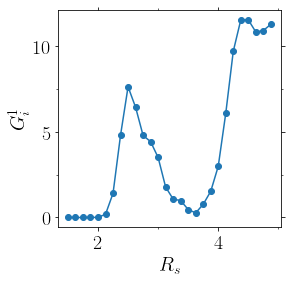

<AxesSubplot:xlabel='$R_s$', ylabel='$G^1_i$'>

In [29]:
PltErr(rbars,structFuncRad[0,0:len(rbars)],
       yerr=None,
       xstr=r'$R_s$',
       ystr=r'$G^1_i$',
       title='%s/G1i.png'%path,
      )